In [1]:
import os


In [2]:
import torch
import numpy as np
from data import Task1Data, Task2Data, Task3Data
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
norm_dataset = Task1Data()
abide_dataset = Task2Data()
mci_dataset = Task3Data(no=2)
ad_dataset = Task3Data(no=1)


(712, 62, 2) (712,) (712,)
(999, 62, 2) (999,) (999,)
(649, 62, 2) (649,) (649,)
Finding files: 2360/2360/2360
Finding files: 1031/1031/1031
Finding files: 712/712/712
380/332
Finding files: 604/604/604
272/332


In [80]:
sex_0_mean = np.zeros((100,62))
sex_0_std = np.zeros((100,62))
sex_1_mean = np.zeros((100,62))
sex_1_std = np.zeros((100,62))

In [184]:
name = 'res/mask_bugfix8_claude_schedule_norm5/'
name = 'res/mask_bugfix8_claude_schedule_norm5_rerun//'
for sex in range(2):
    for age in range(100):
        dat = np.load(f"{name}//sex-{sex}_age-{age}.npy")
        if sex == 0:
            sex_0_mean[age] = dat.mean(0).reshape(-1)[:62]
            sex_0_std[age] = dat.std(0).reshape(-1)[:62]
        else:
            sex_1_mean[age] = dat.mean(0).reshape(-1)[:62]
            sex_1_std[age] = dat.std(0).reshape(-1)[:62]

In [185]:
mean_training_data_sex_0 = np.zeros((100,62))
mean_training_data_sex_1 = np.zeros((100,62))

for sex in range(2):
    for age in range(100):
        if sex == 0:
            mean_training_data_sex_0[age] = norm_dataset.ct_feas[(norm_dataset.sexs==0) & (norm_dataset.ages==age)][...,0].mean(0).reshape(-1)[:62]
        else:
            mean_training_data_sex_1[age] = norm_dataset.ct_feas[(norm_dataset.sexs==1) & (norm_dataset.ages==age)][...,0].mean(0).reshape(-1)[:62]
            

ours: 0.034 gpr: 0.034


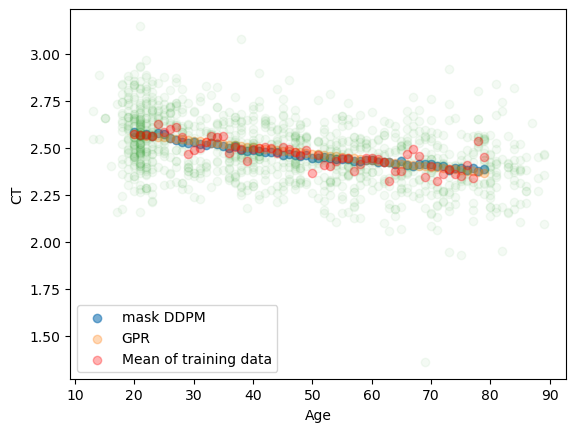

In [186]:
roi = 0
st=20
end = 80
x_constant = sm.add_constant(norm_dataset.ages[norm_dataset.sexs==0].reshape(-1,1))
model = sm.GLM(norm_dataset.ct_feas[:,roi,0][norm_dataset.sexs==0].reshape(-1,1), x_constant, family=sm.families.Gaussian())
results = model.fit()
pred = results.predict(sm.add_constant(np.array(range(100)).reshape(-1,1)))

plt.scatter(range(100)[st:end], (sex_0_mean[st:end,roi] + 0) / 1 * 5, label = 'mask DDPM',alpha=0.6)
plt.scatter(range(100)[st:end], pred[st:end] * 5, label = 'GPR',alpha=0.3)
plt.scatter(norm_dataset.ages[norm_dataset.sexs==0].reshape(-1),norm_dataset.ct_feas[:,roi,0][norm_dataset.sexs==0]*5,alpha=0.05)
plt.scatter(range(100)[st:end], mean_training_data_sex_0[st:end,roi]*5,alpha=0.3,color='red',label='Mean of training data')
error_mask =  np.abs(mean_training_data_sex_0[st:end,roi]*5 - (sex_0_mean[st:end,roi] + 0) / 1 * 5).mean()
error_gpr =  np.abs(pred[st:end] * 5 - mean_training_data_sex_0[st:end,roi]*5).mean()
print(f"ours: {error_mask:.3f} gpr: {error_gpr:.3f}")
plt.xlabel("Age")
plt.ylabel("CT")
plt.legend()

ours: 0.030 gpr: 0.029


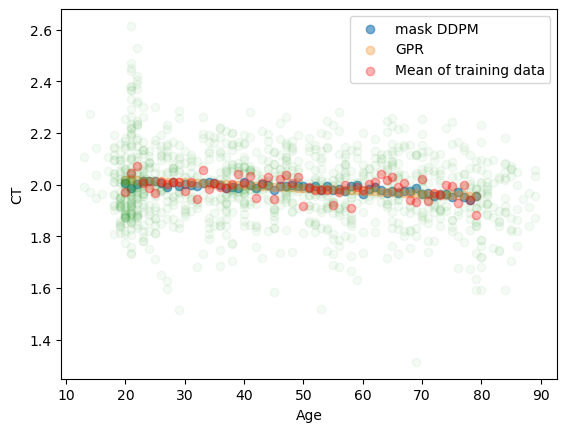

In [187]:
roi = 10
st=20
end = 80
x_constant = sm.add_constant(norm_dataset.ages[norm_dataset.sexs==0].reshape(-1,1))
model = sm.GLM(norm_dataset.ct_feas[:,roi,0][norm_dataset.sexs==0].reshape(-1,1), x_constant, family=sm.families.Gaussian())
results = model.fit()
pred = results.predict(sm.add_constant(np.array(range(100)).reshape(-1,1)))

plt.scatter(range(100)[st:end], (sex_0_mean[st:end,roi] + 0) / 1 * 5, label = 'mask DDPM',alpha=0.6)
plt.scatter(range(100)[st:end], pred[st:end] * 5, label = 'GPR',alpha=0.3)
plt.scatter(norm_dataset.ages[norm_dataset.sexs==0].reshape(-1),norm_dataset.ct_feas[:,roi,0][norm_dataset.sexs==0]*5,alpha=0.05)
plt.scatter(range(100)[st:end], mean_training_data_sex_0[st:end,roi]*5,alpha=0.3,color='red',label='Mean of training data')
error_mask =  np.abs(mean_training_data_sex_0[st:end,roi]*5 - (sex_0_mean[st:end,roi] + 0) / 1 * 5).mean()
error_gpr =  np.abs(pred[st:end] * 5 - mean_training_data_sex_0[st:end,roi]*5).mean()
print(f"ours: {error_mask:.3f} gpr: {error_gpr:.3f}")
plt.xlabel("Age")
plt.ylabel("CT")
plt.legend()

In [188]:
ours_errors = []
gpr_errors = []
for sex in range(2):
    for roi in range(62):
        x_constant = sm.add_constant(norm_dataset.ages[norm_dataset.sexs==sex].reshape(-1,1))
        model = sm.GLM(norm_dataset.ct_feas[:,roi,0][norm_dataset.sexs==sex].reshape(-1,1), x_constant, family=sm.families.Gaussian())
        results = model.fit()
        pred = results.predict(sm.add_constant(np.array(range(100)).reshape(-1,1)))

        if sex == 0:
            mean_val = mean_training_data_sex_0
            mine_mean = sex_0_mean
        else:
            mean_val = mean_training_data_sex_1
            mine_mean = sex_1_mean
        # error_mask =  ((mean_val[st:end,roi]*5 - (mine_mean[st:end,roi] + 0) / 1 * 5) ** 2).mean()
        error_mask =  (np.abs(mean_val[st:end,roi]*5 - (mine_mean[st:end,roi] + 0) / 1 * 5)).mean()
        # error_gpr =  ((pred[st:end] * 5 - mean_val[st:end,roi]*5)**2).mean()
        error_gpr =  (np.abs(pred[st:end] * 5 - mean_val[st:end,roi]*5)).mean()
        # print(f"{sex}-{roi} ours: {error_mask:.3f} gpr: {error_gpr:.3f}")
        ours_errors.append(error_mask)
        gpr_errors.append(error_gpr)

print(f"ours:{np.mean(ours_errors)} gpr:{np.mean(gpr_errors)}")

ours:0.034850945710817545 gpr:0.03695854151813905


In [189]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [190]:
use_feas = abide_dataset.ct_feas[:,:,0] / 5
use_age = abide_dataset.ages
use_sex = abide_dataset.sexs
use_dx = abide_dataset.dx

mine_feas = np.zeros_like(use_feas)
for i in range(len(use_feas)):
    if use_sex[i] == 0:
        mean = sex_0_mean[use_age[i]]
        var = sex_0_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    elif use_sex[i] == 1:
        mean = sex_1_mean[use_age[i]]
        var = sex_1_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    else:
        print("error")

In [191]:
svm1 = SVC()
svm2 = SVC()

pipeline = make_pipeline(svm1)
X = use_feas.reshape((len(use_feas), -1))
y = use_dx
# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# 计算交叉验证的分数
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')

# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

print("*" * 40)
X2 = mine_feas
y = use_dx
# pipeline2 = make_pipeline(svm)
pipeline2 = make_pipeline(svm2)

scores2 = cross_val_score(pipeline2, X2, y, cv=kf, scoring='accuracy')
# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores2}")
print(f"Mean accuracy: {scores2.mean():.2f}")

Cross-validation scores: [0.55072464 0.46601942 0.51941748 0.52427184 0.56796117]
Mean accuracy: 0.53
****************************************
Cross-validation scores: [0.58937198 0.50485437 0.52912621 0.5631068  0.52912621]
Mean accuracy: 0.54


In [192]:
use_feas = mci_dataset.ct_feas[:,:,0] / 5
use_age = mci_dataset.ages
use_sex = mci_dataset.sexs
use_dx = mci_dataset.dx

mine_feas = np.zeros_like(use_feas)
for i in range(len(use_feas)):
    if use_sex[i] == 0:
        mean = sex_0_mean[use_age[i]]
        var = sex_0_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    elif use_sex[i] == 1:
        mean = sex_1_mean[use_age[i]]
        var = sex_1_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    else:
        print("error")

In [193]:
svm1 = SVC()
svm2 = SVC()

pipeline = make_pipeline(StandardScaler(), svm1)
X = use_feas.reshape((len(use_feas), -1))
y = use_dx
# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 计算交叉验证的分数
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')

# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

print("*" * 40)
X2 = mine_feas
y = use_dx
pipeline2 = make_pipeline(StandardScaler(),svm2)

scores2 = cross_val_score(pipeline2, X2, y, cv=kf, scoring='accuracy')

# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores2}")
print(f"Mean accuracy: {scores2.mean():.2f}")

Cross-validation scores: [0.58041958 0.53846154 0.59859155 0.55633803 0.56338028]
Mean accuracy: 0.57
****************************************
Cross-validation scores: [0.64335664 0.59440559 0.63380282 0.58450704 0.59859155]
Mean accuracy: 0.61


In [194]:
use_feas = ad_dataset.ct_feas[:,:,0] / 5
use_age = ad_dataset.ages
use_sex = ad_dataset.sexs
use_dx = ad_dataset.dx
mine_feas = np.zeros_like(use_feas)
for i in range(len(use_feas)):
    if use_sex[i] == 0:
        mean = sex_0_mean[use_age[i]]
        var = sex_0_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    elif use_sex[i] == 1:
        mean = sex_1_mean[use_age[i]]
        var = sex_1_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    else:
        print("error")

In [204]:
svm1 = SVC()
svm2 = SVC()

pipeline = make_pipeline(StandardScaler(), svm1)
X = use_feas.reshape((len(use_feas), -1))
y = use_dx
# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=8)

# 计算交叉验证的分数
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')

# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

print("*" * 40)
X2 = mine_feas
y = use_dx
pipeline2 = make_pipeline(StandardScaler(),svm2)
scores2 = cross_val_score(pipeline2, X2, y, cv=kf, scoring='accuracy')
# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores2}")
print(f"Mean accuracy: {scores2.mean():.2f}")

Cross-validation scores: [0.84297521 0.82644628 0.89256198 0.91735537 0.93333333]
Mean accuracy: 0.88
****************************************
Cross-validation scores: [0.8677686  0.81818182 0.90909091 0.94214876 0.91666667]
Mean accuracy: 0.89


In [234]:
age=12
sex=0

In [235]:
dat = np.load(f"{name}//sex-{sex}_age-{age}.npy")

(0.4, 0.7)

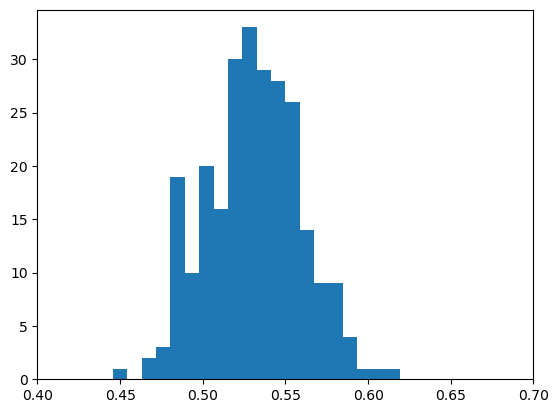

In [236]:
plt.hist(dat[:,0],bins=20)
plt.xlim([0.4,0.7])

(0.4, 0.7)

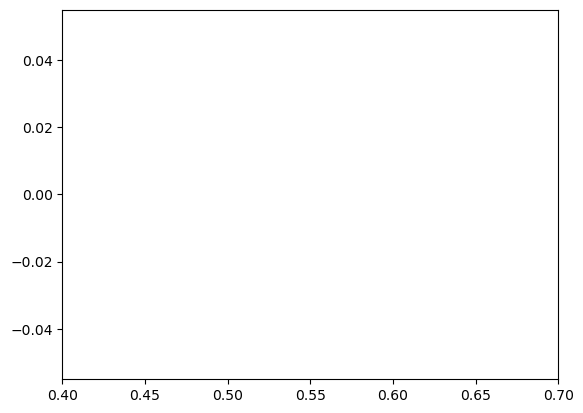

In [237]:
plt.hist(norm_dataset.ct_feas[(norm_dataset.sexs==0) & (norm_dataset.ages==age)][...,0][:,0],bins=20)
plt.xlim([0.4,0.7])
